In [25]:
traj_module = EMRIInspiral(func="pn5")

# set initial parameters
M = 1e6
mu = 5e1
e0 = 0.7

traj_args = [M, mu, 0.9, e0, 1.0]
traj_kwargs = inspiral_kwargs.copy()
index_of_p = 3

t_out = 1.5
# run trajectory

aa=time.time()
p_new = get_p_at_t(
    traj_module,
    t_out,
    traj_args,
    index_of_p=3,
    index_of_a=2,
    index_of_e=4,
    index_of_x=5,
    traj_kwargs={},
    xtol=2e-12,
    rtol=8.881784197001252e-16,
    bounds=None,
)
print(p_new)
print(time.time()-aa)

11.52946198561113
0.7040777206420898


In [44]:
import sys, os, time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from few.trajectory.inspiral import EMRIInspiral
from few.waveform import GenerateEMRIWaveform,Pn5AAKWaveform, AAKWaveformBase
from few.summation.aakwave import AAKSummation
from few.utils.utility import *

import GWGen; from GWGen.WFGenerator import *

# set initial parameters
M = 1e5
mu = 1e1
a = .6
p0 = 10.0
e0 = 0.3
iota0 = 0.
Y0 = np.cos(iota0)
Phi_phi0 = 0.
Phi_theta0 = 0.
Phi_r0 = 0.

qS = 0.2
phiS = 0.2
qK = 0.8
phiK = 0.8
dist = 1.0
mich = False
dt = 15
T = 1.5

use_gpu = True

# keyword arguments for inspiral generator (RunKerrGenericPn5Inspiral)
inspiral_kwargs = {
    "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    "npoints":100,
    "dense_output":True,
    "time_resolution":3e4,
    "func":"pn5"
}

# keyword arguments for summation generator (AAKSummation)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

fewtraj = EMRIInspiral(func="pn5")
mytraj = PNTraj()

In [45]:
# run trajectory
fewtrajdata = fewtraj(M, mu, a, p0, e0, Y0, T=T,dt=dt,**inspiral_kwargs)
mytrajdata = mytraj(M,mu,a, p0,e0,Y0,T=T,**inspiral_kwargs)

Integration halted before ending time. Reasons: Separatrix reached!


In [46]:
print(len(mytrajdata[0]))
print(len(fewtrajdata[0]))

60
95


In [47]:
AAK = AAKWaveformBase(PNTraj, AAKSummation,inspiral_kwargs=inspiral_kwargs.copy(), sum_kwargs=sum_kwargs.copy(),use_gpu=use_gpu)

In [48]:
dat = tuple((np.require(i, dtype=np.float64, requirements="O") for i in fewtrajdata))
num_modes_kept = nmodes = int(30 * e0)
if num_modes_kept < 4:
    num_modes_kept = nmodes = 4
fewwf = AAK.create_waveform(dat[0], M, a,*dat[1:], mu, qS, phiS, qK, phiK, dist, nmodes,mich=mich,dt=dt,T=T)

In [49]:
dat = mytrajdata
num_modes_kept = nmodes = int(30 * e0)
if num_modes_kept < 4:
    num_modes_kept = nmodes = 4
mywf = AAK.create_waveform(dat[0], M, a,*dat[1:], mu, qS, phiS, qK, phiK, dist, nmodes,mich=mich,dt=dt,T=T)

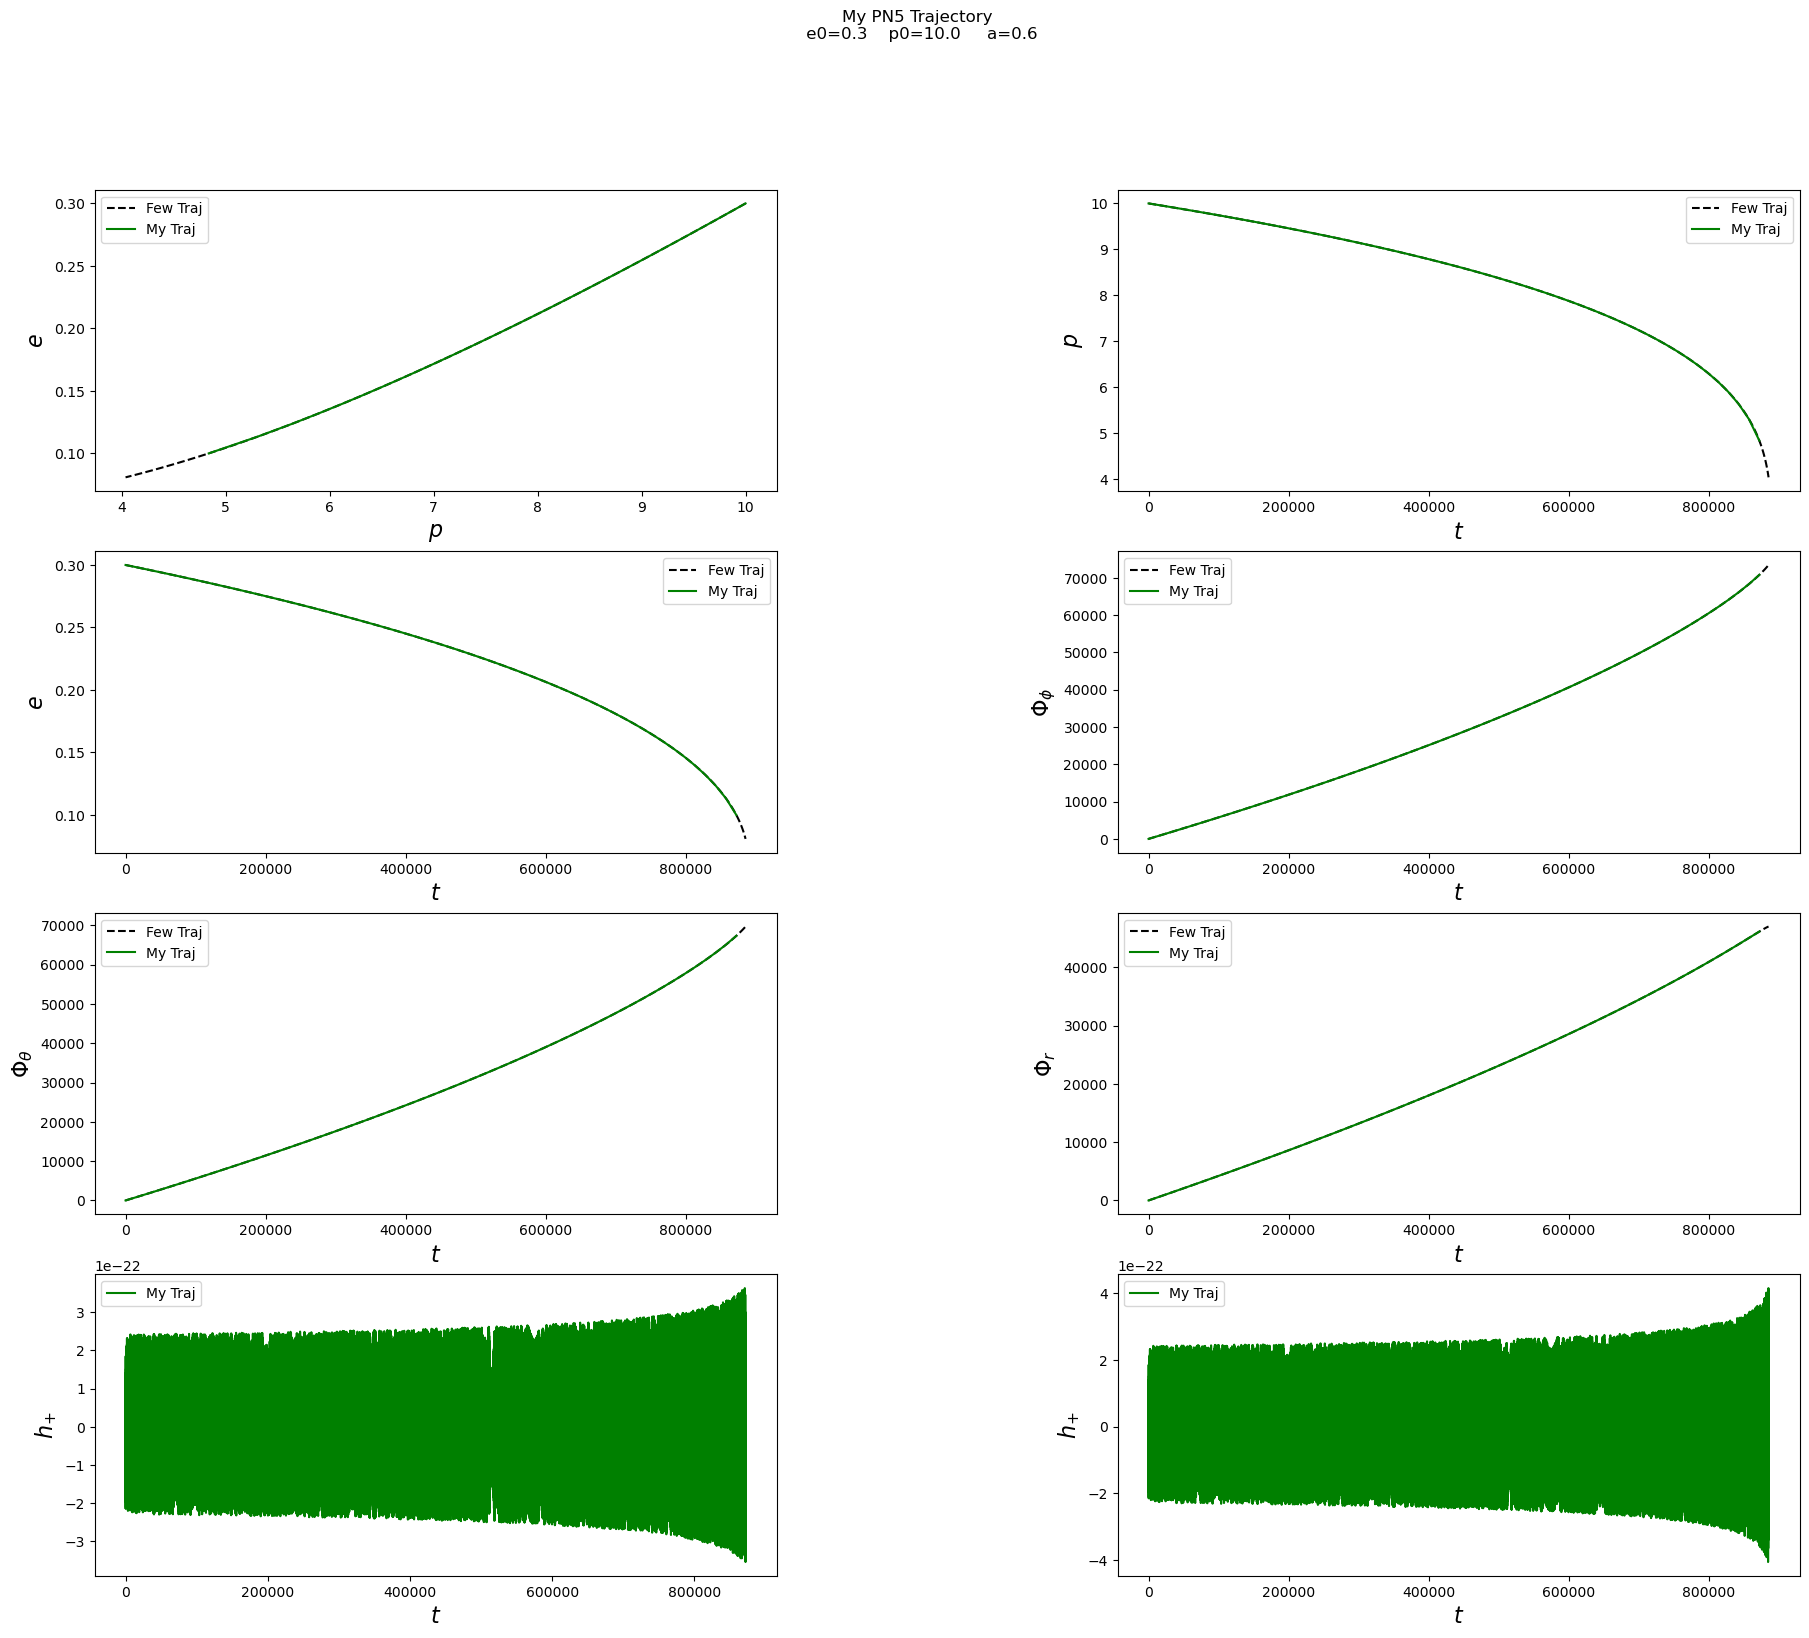

In [50]:
#Plot Trajectories
fig, axes = plt.subplots(4, 2)
plt.subplots_adjust(wspace=0.5)
fig.set_size_inches(22, 18)
axes = axes.ravel()
ylabels = [r'$e$', r'$p$', r'$e$', r'$\Phi_\phi$', r'$\Phi_\theta$', r'$\Phi_r$', r'$h_{+}$',r'$h_{+}$']
xlabels = [r'$p$', r'$t$',  r'$t$',  r'$t$',               r'$t$',                     r'$t$',            r'$t$',  r'$t$']
datlabel = ["Few Traj",  "My Traj"]
datcolors = ["black", "green", "blue", "yellow", "orange"]
datstyle= ["dashed", "solid", "dashdot", "dotted"]
xdata = [1,0,0,0,0,0]
ydata = [2,1,2,4,5,6]
for i, (ax, xlab, ylab) in enumerate(zip(axes, xlabels, ylabels)):
    if i<len(xdata):
        fx = fewtrajdata[xdata[i]]
        fy = fewtrajdata[ydata[i]]
        mx = mytrajdata[xdata[i]]
        my = mytrajdata[ydata[i]]
        ax.plot(fx,fy, label=datlabel[0],color=datcolors[0], linestyle=datstyle[0])
        ax.plot(mx,my, label=datlabel[1],color=datcolors[1], linestyle=datstyle[1])
    elif i==len(xdata):
        mx = np.arange(len(mywf.get()))*dt
        my = mywf.get().real
        ax.plot(mx,my, label=datlabel[1],color=datcolors[1], linestyle=datstyle[1])
    else:
        fx = np.arange(len(fewwf.get()))*dt
        fy = fewwf.get().real
        ax.plot(fx,fy, label=datlabel[1],color=datcolors[1], linestyle=datstyle[1])


    ax.set_xlabel(xlab, fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)
    ax.legend()
fig.suptitle("My PN5 Trajectory \n e0={0}    p0={1}     a={2}".format(e0,p0,a));